In [108]:
import re
import nltk
import spacy
import pyLDAvis
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
import en_core_web_sm
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [51]:
from sklearn import set_config

In [52]:
set_config(display='diagram')

In [53]:
fname = './data/bbc-text.csv'
df = pd.read_csv(fname)

In [54]:
df.shape

(2225, 2)

In [82]:
# df.head()

### Preprocessing

In [56]:
# removing emails
df['text'] = df['text'].str.replace(r'\s*@\s*\s?', '', regex=True)
# removing new lines
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
# removing single quotes
df['text'] = df['text'].str.replace(r'\'', '', regex=True)

In [57]:
df['text'] = df['text'].apply(lambda x: simple_preprocess(str(x), deacc=True))

In [62]:
stop_words = set(nltk.corpus.stopwords.words('english'))
# removing stop words
df['text'] = df['text'].apply(lambda row: [word for word in row if word not in stop_words])

In [67]:
nlp = en_core_web_sm.load()
allowed_postags = ['NOUN']
df['text'] = df['text'].apply(lambda row: nlp(' '.join(row)))
# lemmatizing words
df['text'] = df['text'].apply(lambda row: [token.lemma_ for token in row if token.pos_ in allowed_postags])

### LDA

In [79]:
id2word =corpora.Dictionary(df['text'])  # dictionary input to LDA

In [80]:
corpus = [id2word.doc2bow(row) for row in df['text']]  # corpus input to LDA

In [81]:
# lda model
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5,
                                      random_state=4, chunksize=200, passes=10, per_word_topics=True)

In [83]:
lda.print_topics()

[(0,
  '0.033*"game" + 0.018*"time" + 0.018*"player" + 0.018*"year" + 0.011*"team" + 0.010*"side" + 0.010*"club" + 0.009*"week" + 0.008*"match" + 0.008*"goal"'),
 (1,
  '0.026*"year" + 0.024*"sale" + 0.017*"company" + 0.016*"market" + 0.012*"price" + 0.010*"firm" + 0.010*"car" + 0.010*"growth" + 0.009*"month" + 0.008*"figure"'),
 (2,
  '0.019*"government" + 0.015*"people" + 0.014*"party" + 0.011*"election" + 0.010*"year" + 0.009*"labour" + 0.008*"country" + 0.008*"plan" + 0.008*"tax" + 0.008*"law"'),
 (3,
  '0.029*"people" + 0.017*"phone" + 0.016*"attack" + 0.014*"technology" + 0.014*"network" + 0.014*"computer" + 0.013*"site" + 0.013*"service" + 0.012*"software" + 0.012*"user"'),
 (4,
  '0.035*"film" + 0.019*"music" + 0.019*"tv" + 0.018*"year" + 0.014*"award" + 0.009*"number" + 0.009*"show" + 0.008*"album" + 0.008*"song" + 0.008*"cinema"')]

In [87]:
doc_lda = lda[corpus]

In [88]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=id2word, coherence='c_v',)
coherence_lda = coherence_model_lda.get_coherence()

In [89]:
print(f'Coherence score {coherence_lda}')

Coherence score 0.5228594678620321


#### Tuning LDA to increase coherence

In [91]:
def compute_coherence_values(dictionary, corpus, text, limit, start=2, step=1):
    coherence_value = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                                              random_state=4, chunksize=200, passes=10, per_word_topics=True)
        model_list.append(lda)
        coherence_model = CoherenceModel(model=lda, texts=text, dictionary=dictionary, coherence='c_v',)
        coherence_value.append(coherence_model.get_coherence())
    return coherence_value, model_list

In [92]:
coherence_value, model_list = compute_coherence_values(id2word, corpus, df['text'], limit=8, start=2, step=1)

In [ ]:
# more tuning available ...

### Graphing

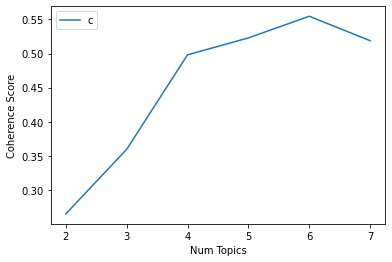

In [96]:
x = range(2, 8, 1)
plt.plot(x, coherence_value)
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.legend('coherence values', loc='best')
plt.show()

### Viz

In [104]:
import pyLDAvis.gensim_models

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

In [106]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.103366 -0.113494       1        1  27.110191
1     -0.125832 -0.149201       2        1  21.893412
0      0.134810 -0.065549       3        1  19.218871
4      0.238637  0.067068       4        1  16.018695
3     -0.144248  0.261175       5        1  15.758831, topic_info=           Term         Freq        Total Category  logprob  loglift
234        film  1074.000000  1074.000000  Default  30.0000  30.0000
159        game  1306.000000  1306.000000  Default  29.0000  29.0000
250        sale  1132.000000  1132.000000  Default  28.0000  28.0000
290  government  1032.000000  1032.000000  Default  27.0000  27.0000
63       people  1935.000000  1935.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
99        video   177.045161   261.816212   Topic5  -5.1253   1.4565
103         way   232.293404   777.514622   Topic5  -4.8537   0.6397
667    security   168.609043   340.731866   Topic5  -5.1742   1.1443
94         time   192.055958  1479.169542   Topic5  -5.0440  -0.1937
207      number   173.317735   825.008478   Topic5  -5.1466   0.2875

[311 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
589       4  0.995950    actor
2784      4  0.989951  actress
502       1  0.866989      age
502       3  0.016205      age
502       4  0.116139      age
...     ...       ...      ...
106       1  0.176545     year
106       2  0.386462     year
106       3  0.229653     year
106       4  0.195922     year
106       5  0.011841     year

[519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

In [109]:
colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

In [111]:
cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=2800, max_words=15, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i], prefer_horizontal=1.0)

In [113]:
topics = lda.show_topics(formatted=False)

IndexError: list index out of range

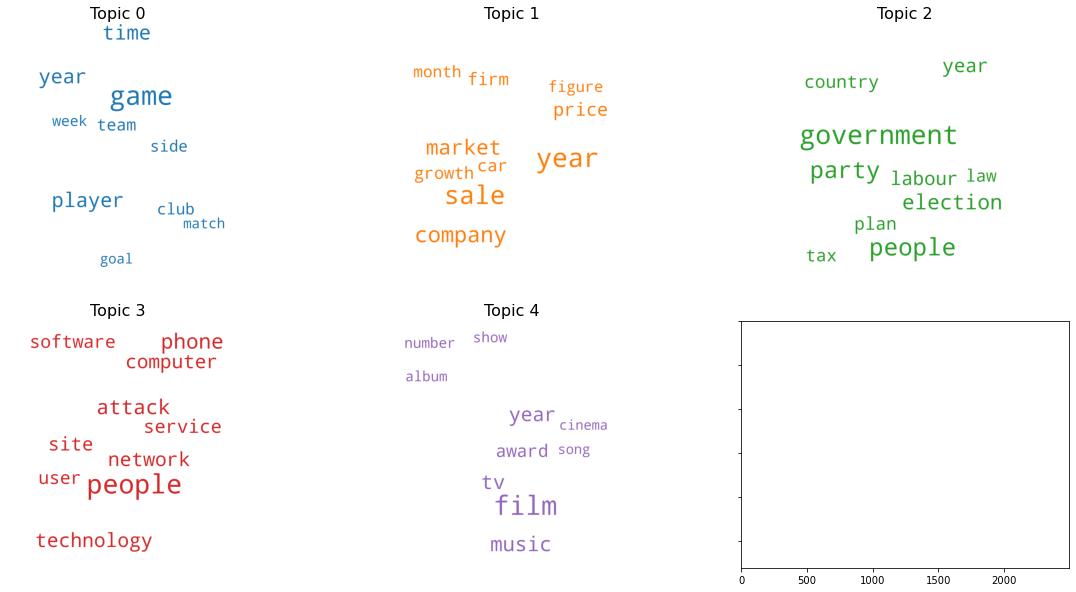

In [121]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(f"Topic {i}", fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()